In [6]:
import numpy as np
import pandas as pd

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [8]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

### Investment Thesis
- Given the current volatile market environment and consistent underperformance of small-cap stocks, is it possible to use inverse ETFs to construct a potential strategy that profits off from the return spread between small-cap and large-cap tech stocks
- This can be used with other pairs of ETFs (SH, QQQ) (SPY, RWM) etc.

In [20]:
qqq = pd.read_csv('../datasets/qqq.csv')
qqq_div = pd.read_csv('../datasets/qqq_div.csv')

rwm = pd.read_csv('../datasets/rwm.csv')
rwm_div = pd.read_csv('../datasets/rwm_div.csv')

In [25]:
qqq = pd.merge(qqq, qqq_div, how='left', on=['Date']).fillna(0)

In [26]:
rwm = pd.merge(rwm, rwm_div, how='left', on=['Date']).fillna(0)

In [29]:
qqq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,44.695953,5232000,0.0
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,44.914772,9688600,0.0
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,43.820618,8743600,0.0
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,45.078896,6369000,0.0
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,45.461845,4905800,0.0


In [30]:
rwm.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends
0,2007-01-25,278.320007,281.320007,277.920013,281.320007,196.387619,500,0.0
1,2007-01-26,281.679993,281.880005,281.559998,281.760010,196.694778,3200,0.0
2,2007-01-29,279.720001,279.720001,277.399994,278.920013,194.712158,900,0.0
3,2007-01-30,276.000000,276.040009,276.000000,276.040009,192.701691,0,0.0
4,2007-01-31,276.920013,276.920013,274.519989,274.519989,191.640549,1200,0.0


In [37]:
stock_1 = 'QQQ'
stock_2 = 'RWM'

### Rebalance Daily at Open
- Due to high fluctuations of prices in trading hours, rebalancing for retail investors can happen at Open based on pre-market open price.

In [198]:
stock_df = pd.merge(qqq, rwm, on=['Date'], how='inner', suffixes=(f'_{stock_1}', f'_{stock_2}'))

In [199]:
stock_df = stock_df.loc[:, ['Date', f'Open_{stock_1}', f'Open_{stock_2}', f'Dividends_{stock_1}', f'Dividends_{stock_2}']]

In [200]:
### Initialize Variables
stock_df[f'{stock_1}_MV'] = 0
stock_df[f'{stock_1}_SHARE'] = 0
stock_df[f'{stock_2}_MV'] = 0
stock_df[f'{stock_2}_SHARE'] = 0
stock_df['DAILY_PNL'] = 0

In [201]:
stock_df.head()

,Date,Open_QQQ,Open_RWM,Dividends_QQQ,Dividends_RWM,QQQ_MV,QQQ_SHARE,RWM_MV,RWM_SHARE,DAILY_PNL
0,2007-01-25,44.360001,278.320007,0.0,0.0,0,0,0,0,0
1,2007-01-26,43.810001,281.679993,0.0,0.0,0,0,0,0,0
2,2007-01-29,43.459999,279.720001,0.0,0.0,0,0,0,0,0
3,2007-01-30,43.680000,276.000000,0.0,0.0,0,0,0,0,0
4,2007-01-31,43.580002,276.920013,0.0,0.0,0,0,0,0,0


### Assumptions
- Initialize with 100K Capital
- No Transaction Cost
- No Dividend

In [229]:
stock_df = stock_df.query('Date > "2018-01-01"').reset_index(drop=True)

In [230]:
stock_df.head()

,Date,Open_QQQ,Open_RWM,Dividends_QQQ,Dividends_RWM,QQQ_MV,QQQ_SHARE,RWM_MV,RWM_SHARE,DAILY_PNL,TOTAL_MV,DAILY_PCT_PNL
0,2018-01-02,156.559998,42.090000,0.0,0.0,232808.422742,1487.023670,232808.422742,5531.205102,1876.140066,465616.845483,0.004029
1,2018-01-03,158.639999,41.869999,0.0,0.0,233736.542775,1473.377107,233736.542775,5582.434878,1462.747288,467473.085550,0.003129
2,2018-01-04,160.580002,41.619999,0.0,0.0,234457.966419,1460.069520,234457.966419,5633.300626,884.457284,468915.932838,0.001886
3,2018-01-05,161.070007,41.650002,0.0,0.0,234890.245061,1458.311510,234890.245061,5639.621459,1465.119598,469780.490121,0.003119
4,2018-01-08,161.919998,41.689999,0.0,0.0,235612.854860,1455.118934,235612.854860,5651.543788,421.601829,471225.709719,0.000895


In [232]:
def long_short(stock_df, init_mv, transaction_cost, dividend):
    
    stock_df.loc[0, [f'{stock_1}_MV', f'{stock_2}_MV']] = init_mv
    stock_df[f'{stock_1}_SHARE'] = stock_df[f'{stock_1}_MV']/stock_df[f'Open_{stock_1}']
    stock_df[f'{stock_2}_SHARE'] = stock_df[f'{stock_2}_MV']/stock_df[f'Open_{stock_2}']
    
    for index, row in stock_df.iloc[1:].iterrows():
    
        prev_row = stock_df.loc[index - 1]
    
        stock_1_p = row[f'Open_{stock_1}']
        stock_2_p = row[f'Open_{stock_2}']
        
        if dividend:
            total_mv = prev_row[f'{stock_1}_SHARE'] * (stock_1_p + prev_row[f'Dividends_{stock_1}']) + prev_row[f'{stock_2}_SHARE'] * (stock_2_p + prev_row[f'Dividends_{stock_2}'])
        else:
            total_mv = prev_row[f'{stock_1}_SHARE'] * stock_1_p + prev_row[f'{stock_2}_SHARE'] * stock_2_p

    
        row['DAILY_PNL'] = total_mv - prev_row[f'{stock_1}_MV'] - prev_row[f'{stock_2}_MV']
    
        row[f'{stock_1}_MV'] = total_mv/2 - transaction_cost
        row[f'{stock_2}_MV'] = total_mv/2 - transaction_cost
    
        row[f'{stock_1}_SHARE'] = row[f'{stock_1}_MV']/stock_1_p
        row[f'{stock_2}_SHARE'] = row[f'{stock_2}_MV']/stock_2_p
    
        stock_df.loc[index] = row
        
    stock_df['TOTAL_MV'] = stock_df[f'{stock_1}_MV'] + stock_df[f'{stock_2}_MV']
    stock_df['DAILY_PNL'] = stock_df['DAILY_PNL'].shift(-1)
    stock_df['DAILY_PCT_PNL'] = stock_df['DAILY_PNL']/stock_df['TOTAL_MV']
    return stock_df

In [233]:
return_df = long_short(stock_df, 250000, 9.95, True)

In [234]:
return_df['Date'] = pd.to_datetime(return_df['Date'])

### Result

In [235]:
# px.line(return_df, 
#         x='Date',  
#         y='TOTAL_MV',
#         title = f'{stock_1}/{stock_2} Long Short Performance since January 2019')

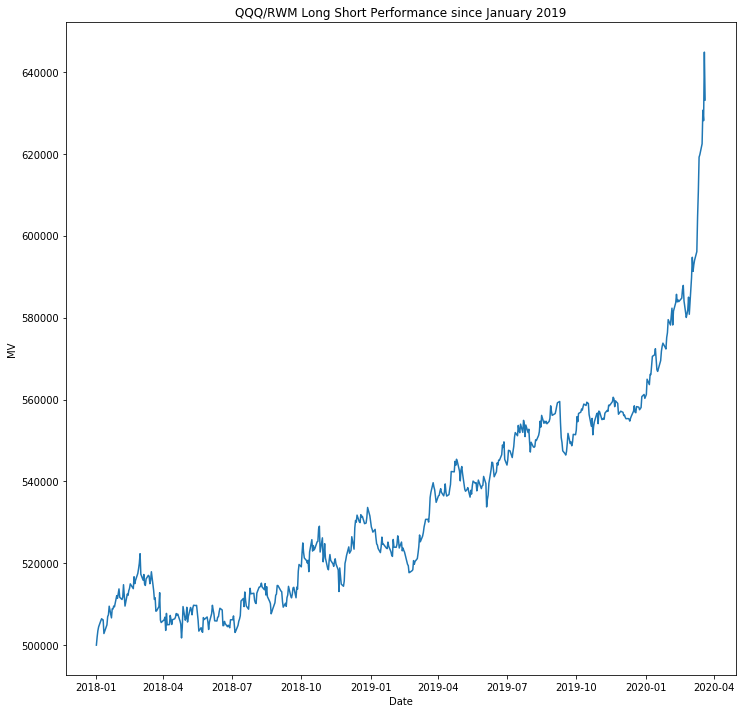

In [236]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='TOTAL_MV', data=return_df);

ax.set(xlabel="Date",
       ylabel="MV",
       title=f'{stock_1}/{stock_2} Long Short Performance since January 2019');

date_form = DateFormatter("%Y-%m");
ax.xaxis.set_major_formatter(date_form);

plt.show()

In [237]:
# px.line(return_df, 
#         x='Date',  
#         y='DAILY_PNL',
#         title = f'{stock_1}/{stock_2} Long Short Daily PNL since January 2019')

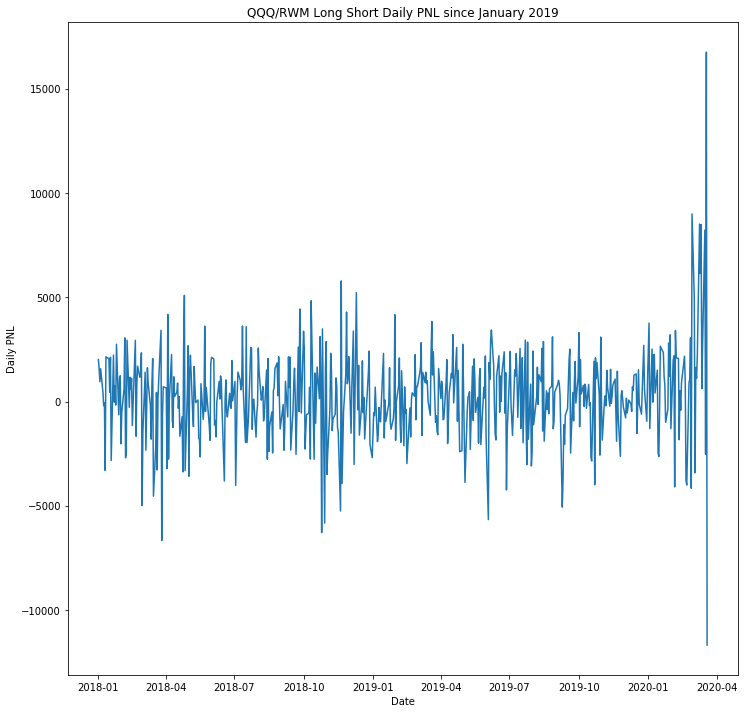

In [238]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='DAILY_PNL', data=return_df);

ax.set(xlabel="Date",
       ylabel="Daily PNL",
       title=f'{stock_1}/{stock_2} Long Short Daily PNL since January 2019');

date_form = DateFormatter("%Y-%m");
ax.xaxis.set_major_formatter(date_form);

plt.show()

In [239]:
# px.line(return_df, 
#         x='Date',  
#         y='DAILY_PCT_PNL',
#         title = f'{stock_1}/{stock_2} Long Short Daily Percentage PNL since January 2019')

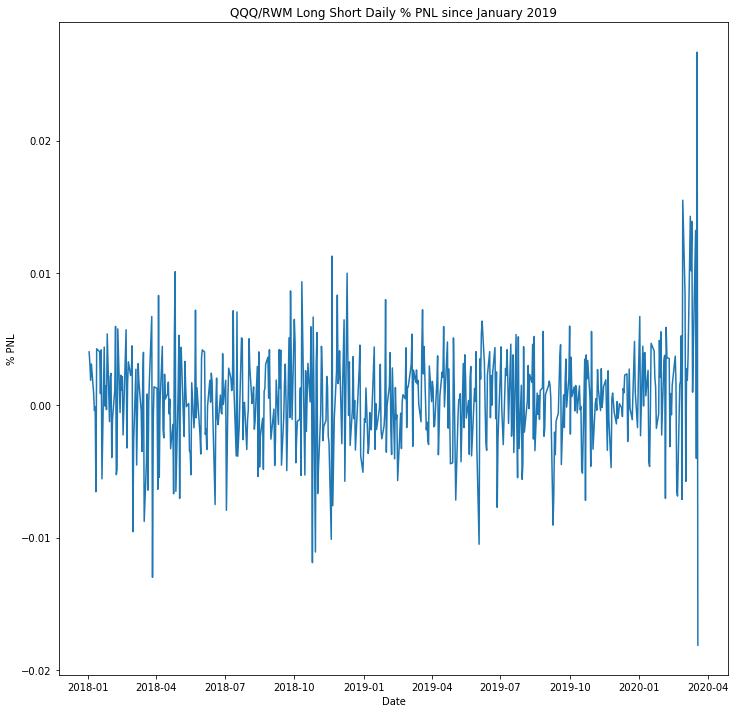

In [240]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.lineplot(x='Date', y='DAILY_PCT_PNL', data=return_df);

ax.set(xlabel="Date",
       ylabel="% PNL",
       title=f'{stock_1}/{stock_2} Long Short Daily % PNL since January 2019');

date_form = DateFormatter("%Y-%m");
ax.xaxis.set_major_formatter(date_form);

plt.show()